In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. importing the necessary Libraries

In [ ]:
#!pip install rouge

import numpy as np
import pandas as pd

import re
import string
import csv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from rouge import Rouge

2 . reading the contents of the file in train_data and test_data

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final project/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final project/test.csv')

train_data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


3 . Dropping the unwanted columns

In [ ]:
train_data = train_data.drop(['id'], axis=1)
train_data = train_data.reset_index(drop=True)
test_data = test_data.drop(['id'], axis=1)
test_data = test_data.reset_index(drop=True)

4 . Preprocessing the data

In [ ]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
def clean_text(text, remove_stopwords=True):
    if isinstance(text, float):
        text = str(text)
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if remove_stopwords and word in stopwords.words('english'):
            continue
        tmp.append(word)
    text = ' '.join(tmp)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    return text


text cleaning

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in train_data.highlights:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')

clean_texts = []
for text in train_data.article:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete')
del train_data

creating pikle file to dump all the clean texts

In [ ]:
import nltk
from nltk.corpus import stopwords
import pickle

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ... (Assuming you have defined the `clean_summaries` and `clean_texts` lists)

# Save clean_summaries to a file
with open('clean_summaries.pkl', 'wb') as f:
    pickle.dump(clean_summaries, f)

# Save clean_texts to a file
with open('clean_texts.pkl', 'wb') as f:
    pickle.dump(clean_texts, f)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


load the file

In [ ]:
import pickle

# Load clean_summaries from the file
with open('/content/drive/MyDrive/Colab Notebooks/final project/clean_summaries.pkl', 'rb') as f:
    clean_summaries = pickle.load(f)

# Load clean_texts from the file
with open('/content/drive/MyDrive/Colab Notebooks/final project/clean_texts.pkl', 'rb') as f:
    clean_texts = pickle.load(f)


create a new dataframe to import all the clean text and summaries

In [ ]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts
clean_df['summary'] = clean_summaries
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')
del clean_texts
del clean_summaries

spilt the  set in ttest and train data

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.1, random_state=0)
del clean_df

tokenize the data

In [ ]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  58.05855337058682
Total Coverage of rare words:  1.6278931824642244
Text Vocab:  58994


In [ ]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  74.11692523446402
Total Coverage of rare words:  6.628488970186565
Summary Vocab:  11812


In [ ]:
maxlen_text = 800
maxlen_summ = 150

In [ ]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [ ]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [ ]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (18899, 800)
Target Values Shape (18899, 150)
Test Sequence (2100, 800)
Target Test Shape (2100, 150)


In [ ]:
embeding_index = {}
embed_dim = 128
'''with open('/content/drive/MyDrive/Colab Notebooks/final project/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs'''

"with open('/content/drive/MyDrive/Colab Notebooks/final project/glove.6B.100d.txt') as f:\n    for line in f:\n        values = line.split()\n        word = values[0]\n        coefs = np.asarray(values[1:], dtype='float32')\n        embeding_index[word] = coefs"

In [ ]:
# t_embed = np.zeros((t_max_features, embed_dim))
# for word, i in t_tokenizer.word_index.items():
#     vec = embeding_index.get(word)
#     if i < t_max_features and vec is not None:
#         t_embed[i] = vec

In [ ]:
# s_embed = np.zeros((s_max_features, embed_dim))
# for word, i in s_tokenizer.word_index.items():
#     vec = embeding_index.get(word)
#     if i < s_max_features and vec is not None:
#         s_embed[i] = vec

In [ ]:
# del embeding_index


5. Preparing the model structure

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 128)     7551232     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 256),        263168      ['embedding[0][0]']              
                                 (None, 128),                                                 

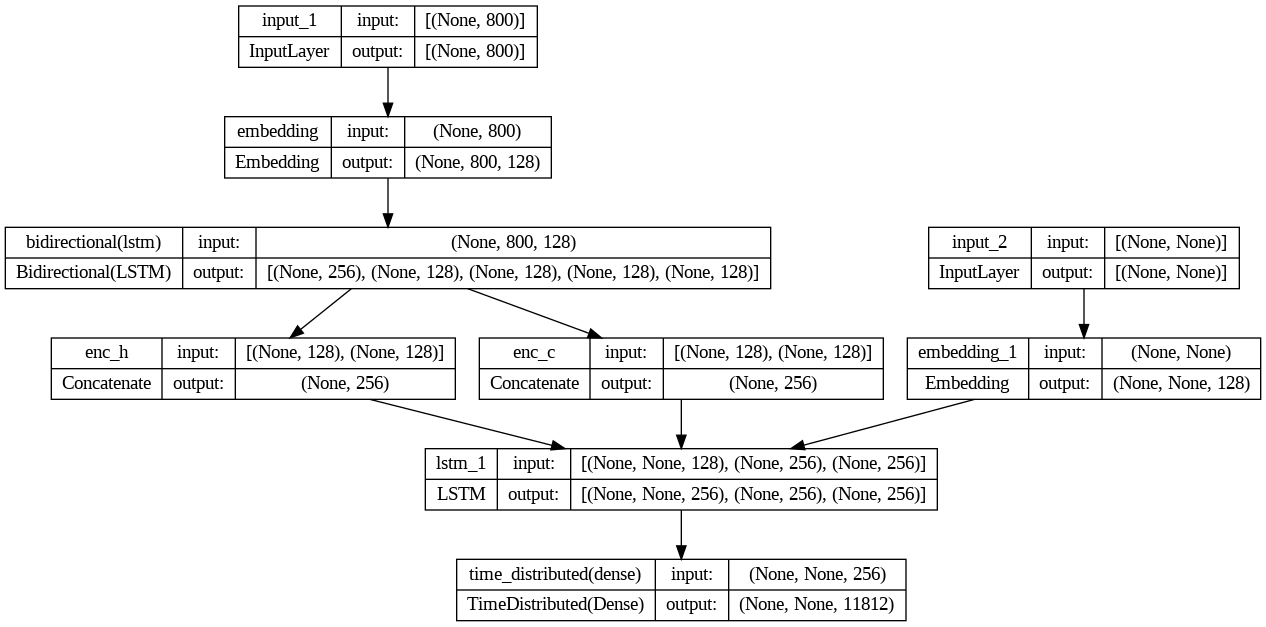

In [ ]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, trainable=True)(enc_input)
# h_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# h_out, _, _ = h_lstm(enc_embed)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])
#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, trainable=True)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

Training the model

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=30, callbacks=[early_stop], batch_size=128, verbose=1, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/30
148/148 [==============================] - 193s 1s/step - loss: 2.8884 - val_loss: 2.1970
Epoch 2/30
148/148 [==============================] - 169s 1s/step - loss: 2.1766 - val_loss: 2.1506
Epoch 3/30
148/148 [==============================] - 167s 1s/step - loss: 2.1590 - val_loss: 2.1401
Epoch 4/30
148/148 [==============================] - 162s 1s/step - loss: 2.1462 - val_loss: 2.1236
Epoch 5/30
148/148 [==============================] - 159s 1s/step - loss: 2.1318 - val_loss: 2.1125
Epoch 6/30
148/148 [==============================] - 160s 1s/step - loss: 2.1209 - val_loss: 2.1030
Epoch 7/30
148/148 [==============================] - 158s 1s/step - loss: 2.1123 - val_loss: 2.0961
Epoch 8/30
148/148 [==============================] - 157s 1s/step - loss: 2.1054 - val_loss: 2.0910
Epoch 9/30
148/148 [==============================] - 157s 1s/step - loss: 2.0994 - val_loss: 2.0838
Epoch 10/30
148/148 [==============================] - 154s 1s/step - loss: 2.0939 - val_lo

Plotting the graph of training loss and validation loss

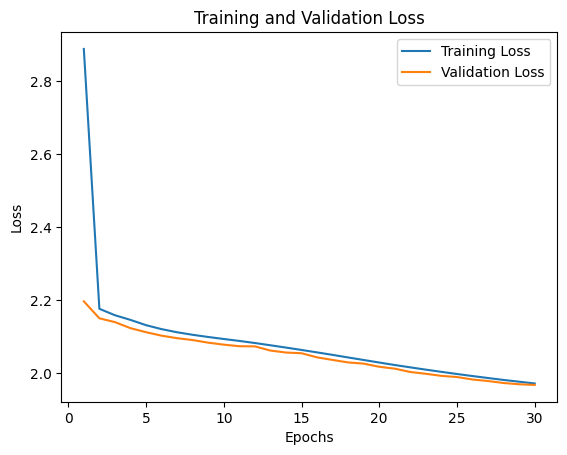

In [ ]:
import matplotlib.pyplot as plt

# Example training data
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
train_loss_values = [2.8884,2.1766,2.1590,2.1462,2.1318,2.1209,2.1123,2.1054,2.0994,2.0939,2.0886,2.0829,2.0767,2.0704,2.0639,2.0572,2.0504,2.0433,2.0364,2.0294,2.0226,2.0162,2.0099,2.0039,1.9980,1.9924,1.9870,1.9817,1.9769,1.9721]
val_loss_values = [2.1970,2.1506,2.1401,2.1236,2.1125,2.1030,2.0961,2.0910,2.0838,2.0784,2.0741,2.0737,2.0622,2.0568,2.0549,2.0436,2.0365,2.0297,2.0264,2.0178,2.0126,2.0035,1.9986,1.9929,1.9897,1.9829,1.9788,1.9733,1.9699,1.9681]

# Plotting the training and validation loss
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


defining the model

In [ ]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

saving the model and train tokeinzer

In [ ]:
import pickle

# Save encoder model
enc_model.save('/content/drive/MyDrive/Colab Notebooks/final project/encoder_model.h5')

# Save decoder model
dec_model.save('/content/drive/MyDrive/Colab Notebooks/final project/decoder_model.h5')

# Save tokenizer
with open('./s_tokenizer.pkl', 'wb') as f:
    pickle.dump(s_tokenizer, f)

function to generate summary

In [ ]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)

    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''

    stop = False
    count = 0

    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])

        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token

        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1

    return output_seq


In [ ]:
test_inputs = [clean_text(sent) for sent in test_data.article]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

loading the model then generating the predicted summary then, saving the original and predicted summary in a separate .csv file

In [ ]:
enc_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/final project/encoder_model.h5')
dec_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/final project/decoder_model.h5')
hyps = []
with open('./result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(100):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_data.article[i], test_data.highlights[i], our_summ])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 84ms/step


function to load the model and generate summary from given user text

In [ ]:
import tensorflow as tf
import numpy as np
import pickle

def generate2_summary2(input_text):
    # Load the tokenizer
    with open('./s_tokenizer.pkl', 'rb') as f:
        s_tokenizer = pickle.load(f)

    # Load the model
    enc_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/final project/encoder_model.h5')
    dec_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/final project/decoder_model.h5')

    # Tokenize the input text
    input_seq = s_tokenizer.texts_to_sequences([input_text])
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=800, padding='post')

    # Generate the summary
    h, c = enc_model.predict(input_seq)

    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''

    stop = False
    count = 0

    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])

        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token

        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1

    return output_seq.strip()

In [ ]:
#text = "Egypt has one of the longest histories of any country, tracing its heritage along the Nile Delta back to the 6th–4th millennia BCE. Considered a cradle of civilisation, Ancient Egypt saw some of the earliest developments of writing, agriculture, urbanisation, organised religion and central government.[14] Iconic monuments such as the Giza Necropolis and its Great Sphinx, as well the ruins of Memphis, Thebes, Karnak, and the Valley of the Kings, reflect this legacy and remain a significant focus of scientific and popular interest. Egypt's long and rich cultural heritage is an integral part of its national identity, which reflects its unique transcontinental location being simultaneously Mediterranean, Middle Eastern and North African.[15] Egypt was an early and important centre of Christianity, but was largely Islamised in the seventh century and remains a predominantly Sunni Muslim country, albeit with a significant Christian minority, along with other lesser practiced faiths."
text="hello my name is Pritam Egypt has one of the longest histories of any country, tracing its heritage along"
get_sum_for_text = generate2_summary2(text)
print(get_sum_for_text)

1/1 [==============================] - 0s 24ms/step
the the york of the york s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s


installing necssary library to find the rogue score

In [ ]:
pip install rogue

  Preparing metadata (setup.py) ... done
  Created wheel for rogue: filename=rogue-0.0.2-py3-none-any.whl size=7210 sha256=566ae9161d2775cf96761e607e2a3dd4e6414820896641492cec27dfa885337f
  Stored in directory: /root/.cache/pip/wheels/11/db/ee/a44bd5d88bd4903f31c1f677a28ac79e354555bca48332f232
Successfully built rogue


In [ ]:
import csv

hyps = []

with open('./result.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header row

    for row in reader:
        hyps.append(row[2])  # Assuming the model output is in the third column

# Print the populated hyps list
print(hyps)
rouge = Rouge()
rouge.get_scores(hyps, test_data.highlights, avg=True, ignore_empty=True)

[' the new york of the first year old was a first year old was a first year old was a first year old was a first year old was a first year to the first year old was a first year to the first year old was a first year to the first year to the first year old was a first year to the first year to the first year old was a first year to the first year to the first year', ' the new york of the first year old was a first year old was a first year old was a first year old was a first year old was a first year to the first year old was a first year to the first year old was a first year to the first year to the first year old was a first year to the first year to the first year', ' the new york of the first year old was a first year old was a first year old was a first year old was a first year old was a first year to the first year old was a first year to the first year old was a first year to the first year to the first year old was a first year to the first year to the first year', ' the new

{'rouge-1': {'r': 0.07276524658964889,
  'p': 0.30500000000000016,
  'f': 0.11598352702767208},
 'rouge-2': {'r': 0.005342582974601845,
  'p': 0.022499999999999996,
  'f': 0.008493592730616516},
 'rouge-l': {'r': 0.06916652273536425,
  'p': 0.28800000000000014,
  'f': 0.11008732866108235}}

In [ ]:
test_inputs2 = clean_text(text)
test_inputs2 = t_tokenizer.texts_to_sequences(list(test_inputs2))
test_inputs2 = pad_sequences(test_inputs2, maxlen=maxlen_text, padding='post')

In [ ]:
for i in range(10):
    our_summ = generate_summary(test_inputs2[i].reshape(1, maxlen_text))
    hyps.append(our_summ)
print(hyps)

1/1 [==============================] - 0s 33ms/step
[' the new york of the first year old was a first year old was a first year old was a first year old was a first year old was a first year to the first year old was a first year to the first year old was a first year to the first year to the first year old was a first year to the first year to the first year old was a first year to the first year to the first year', ' the new york of the first year old was a first year old was a first year old was a first year old was a first year old was a first year to the first year old was a first year to the first year old was a first year to the first year to the first year old was a first year to the first year to the first year', ' the new york of the first year old was a first year old was a first year old was a first year old was a first year old was a first year to the first year old was a first year to the first year old was a first year to the first year to the first year old was a first 

In [ ]:
data2f2 = pd.read_csv('./result.csv')

In [ ]:
data2f2

,Article,Original Summary,Model Output
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,the u s s of the new york s s s new york says...
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,the man was found in the car in the the year ...
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,the first year old was a a in the world s s s...
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,the first year old was a first of the world c...
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...",the man was a a year old in the first year ol...
...,...,...,...
485,"If it feels as though summer has come early, t...",Tomorrow will be week's warmest day and Met Of...,the world s is a new of the world s s s s s s...
486,Things haven't been going well for Manchester ...,Manchester United flop Anderson was sent off f...,the first year old was a first of the world c...
487,"Accused: Officer Aaron Stringer, from Bakersfi...","Officer Aaron Stringer, of Bakersfield, Califo...",the man was arrested in the murder of the yor...
488,A senior writer for the Australian Financial R...,Australian Financial Review writer Geoff Wines...,the u s president obama s s s s s s s s death...
